# Pipeline and Models

In [1]:
# IMPORTS
# DATA MANIPULATION
import pandas as pd
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import set_config; set_config(display='diagram') # Visualize pipelines in HTML
import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree

# STATS
# import statsmodels as sm
# from statsmodels.graphics.gofplots import qqplot

# MACHINE LEARNING
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

To train a model, fit X and y

## Quick EDA (Exploratory Data Analysis)

In [2]:
# Importing Data
oasis1_cs_path = '../raw_data/OASIS1/oasis_cross-sectional.csv'
oasis1 = pd.read_csv(oasis1_cs_path)

In [3]:
# Check shape
oasis1.shape

(436, 12)

✍️ Notes to self:

* **`CDR`** 
    * 0= nondemented;
    * 0.5 – very mild dementia;
    * 1 = mild dementia;
    * 2 = moderate dementia

* **`eTIV`** Estimated total intracranial volume (eTIV)

* **`nWBV`** Normalized whole brain volume

* **`ASF`** Atlas scaling factor

In [4]:
oasis1.sample(20)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
202,OAS1_0222_MR1,F,R,49,NaN,NaN,NaN,NaN,1164,0.805,1.508,NaN
139,OAS1_0150_MR1,F,R,20,NaN,NaN,NaN,NaN,1510,0.875,1.162,NaN
266,OAS1_0294_MR1,F,R,20,NaN,NaN,NaN,NaN,1439,0.841,1.220,NaN
19,OAS1_0021_MR1,F,R,80,3.0,3.0,23.0,0.5,1794,0.765,0.978,NaN
39,OAS1_0043_MR1,M,R,21,NaN,NaN,NaN,NaN,1511,0.846,1.162,NaN
179,OAS1_0197_MR1,F,R,89,3.0,3.0,29.0,0.0,1154,0.747,1.521,NaN
400,OAS1_0442_MR1,F,R,23,NaN,NaN,NaN,NaN,1431,0.847,1.227,NaN
357,OAS1_0395_MR1,F,R,26,NaN,NaN,NaN,NaN,1295,0.834,1.356,NaN
184,OAS1_0202_MR1,F,R,23,NaN,NaN,NaN,NaN,1574,0.865,1.115,NaN
308,OAS1_0341_MR1,F,R,71,2.0,4.0,30.0,0.0,1479,0.772,1.187,NaN


In [5]:
oasis1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


In [6]:
## Preprocessing OASIS1

## Data Cleaning

In [7]:
oasis1["CDR"].value_counts()

0.0    135
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [8]:
def clean_data(df):
    """This function removes CDR rows containing NANs, 
    fills SES missing values with status 3,
    encodes Male/Female M/F to 1 and 0,
    and drops columns Delay and Hand."""
    
    # Imputing with the median value 
    df['SES'].fillna(value=3, inplace=True) 
    
    # DROPPING ROWS WITHOUT TARGET
    df.dropna(subset = ["CDR"], inplace = True)
    
    
    # TARGET
    df["CDR"] = df["CDR"].map({0:0, 
                                     0.5:1, 
                                     1:1, 
                                     2:1})
    
    # DROPPING USELESS FEATURES
    df.drop('Delay', inplace = True, axis=1)
    df.drop('Hand', inplace = True, axis=1)
    df.drop('ID', inplace = True, axis=1)
    
    return df.reset_index(drop = True)

In [9]:
oasis1 = clean_data(oasis1)
oasis1

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,1,1454,0.708,1.207
3,M,74,5.0,2.0,30.0,0,1636,0.689,1.073
4,F,52,3.0,2.0,30.0,0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...
230,F,70,1.0,4.0,29.0,1,1295,0.748,1.355
231,F,73,3.0,2.0,23.0,1,1536,0.730,1.142
232,F,61,2.0,4.0,28.0,0,1354,0.825,1.297
233,M,61,5.0,2.0,30.0,0,1637,0.780,1.072


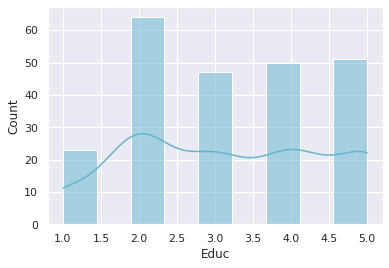

In [10]:
# Education is not normally distrbuted
sns.histplot(oasis1.Educ,kde = True, color = 'c');

In [11]:
# Check whether NANs are still here
oasis1.CDR.value_counts()

0    135
1    100
Name: CDR, dtype: int64

## Preprocessing pipeline

### Defining features and targets

In [12]:
# Defining variables
X = oasis1.drop(columns = ['CDR'])
y = oasis1['CDR']

In [13]:
X

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,1454,0.708,1.207
3,M,74,5.0,2.0,30.0,1636,0.689,1.073
4,F,52,3.0,2.0,30.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...
230,F,70,1.0,4.0,29.0,1295,0.748,1.355
231,F,73,3.0,2.0,23.0,1536,0.730,1.142
232,F,61,2.0,4.0,28.0,1354,0.825,1.297
233,M,61,5.0,2.0,30.0,1637,0.780,1.072


👉 Notes: 

* Columns **nWBV and ASF** already normalized
 
* **Columns to scale:**
    * Standard Scale: age
    * Robust Scale: eTIV, MMSE
    * MinMax Scale: Educ

### CustomColumnTransformer

This custom CT is based on the real one but it also preserves the columns' names

In [14]:
class CustomColumnTransformer(ColumnTransformer):
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns = self.get_feature_names_out())
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns = self.get_feature_names_out())

### Keeping Names

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# TransformerMixin is a SKLearn class used to create custom transformers
# It is coded to have a .fit() to store parameters...
# ... and a .transform() that all transforers need because... they are transformers !

# BaseEstimator is a SKLearn class used to access methods such as .get_params()...
# We have to create a class which name is the name of our own homemade transformer


class  ColumnNameExtractorAfterImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, *_):
        return self

    def transform(self, X, *_):
        return pd.DataFrame(X, columns = self.columns)

### Numerical Column Transformer

In [16]:
# transformer for numerical features

def numerical_pipeline():
    """This function transforms all numerical features according to their respective scalers
    """
    
    # Simple Imputer
    # simple_imputer_frequent = SimpleImputer(strategy = "most_frequent")
    
    # Scalers
    standard_features = ['Age']
    robust_features = ['eTIV', 'MMSE']
    minmax_features = ['Educ', 'SES']
    nothing_to_scale = ['nWBV','ASF']
    
    features_in_this_order = standard_features + robust_features + minmax_features + nothing_to_scale
    
    numerical_transformer = CustomColumnTransformer([
        ('standard_scaler', StandardScaler(), standard_features),
        ('robust_scaler', RobustScaler(), robust_features),
        ('minmax_scaler', MinMaxScaler(), minmax_features),
         ], remainder = 'passthrough')
    
    # Pipeline
    
    numerical_pipeline = Pipeline([
        #("simple_imputer_most_frequent", simple_imputer_frequent),
        #("keeping_column_names", ColumnNameExtractorAfterImputer(features_in_this_order)),
        ("numerical_transformer", numerical_transformer)
    ])
    
    return numerical_pipeline

numerical_pipeline = numerical_pipeline()
numerical_pipeline

Pipeline(steps=[('numerical_transformer',
                 CustomColumnTransformer(remainder='passthrough',
                                         transformers=[('standard_scaler',
                                                        StandardScaler(),
                                                        ['Age']),
                                                       ('robust_scaler',
                                                        RobustScaler(),
                                                        ['eTIV', 'MMSE']),
                                                       ('minmax_scaler',
                                                        MinMaxScaler(),
                                                        ['Educ', 'SES'])]))])

In [17]:
# StandardScaler().fit_transform(X[["Age"]])
# RobustScaler().fit_transform(X[["eTIV"]])
# RobustScaler().fit_transform(X[["MMSE"]])
# MinMaxScaler().fit_transform(X[["Educ"]])
# X[["nWBV"]]
# X[["ASF"]]
# X[["SES"]]

In [18]:
standard_features = ['Age']
robust_features = ['eTIV', 'MMSE']
minmax_features = ['Educ', 'SES']
nothing_to_scale = ['nWBV','ASF']

numerical_features = standard_features + robust_features + minmax_features + nothing_to_scale

In [19]:
numerical_pipeline.fit_transform(X[numerical_features])

,standard_scaler__Age,robust_scaler__eTIV,robust_scaler__MMSE,minmax_scaler__Educ,minmax_scaler__SES,remainder__nWBV,remainder__ASF
0,0.137193,-0.515,0.00,0.25,0.50,0.743,1.306
1,-1.437530,-1.500,0.00,0.75,0.00,0.810,1.531
2,0.054313,0.035,-0.50,0.75,0.50,0.708,1.207
3,0.137193,0.945,0.25,1.00,0.25,0.689,1.073
4,-1.686170,-0.630,0.25,0.50,0.25,0.827,1.329
...,...,...,...,...,...,...,...
230,-0.194328,-0.760,0.00,0.00,0.75,0.748,1.355
231,0.054313,0.445,-1.50,0.50,0.25,0.730,1.142
232,-0.940249,-0.465,-0.25,0.25,0.75,0.825,1.297
233,-0.940249,0.950,0.25,1.00,0.25,0.780,1.072


### Categorical Transformer

In [20]:
binary_categorical_features = ['M/F']

In [21]:
# Transformer for categorical features

def binary_categorical_transformer():
    """This function encodes all categorical features according to their respective encoder.
    """
    categorical_transformer = CustomColumnTransformer([
       ("ohe_binary", 
         OneHotEncoder(sparse = False,
                       drop = "if_binary", 
                       handle_unknown = "error"), 
         binary_categorical_features)
    ])
    return categorical_transformer

binary_category_transformer = binary_categorical_transformer()
binary_category_transformer

CustomColumnTransformer(transformers=[('ohe_binary',
                                       OneHotEncoder(drop='if_binary',
                                                     sparse=False),
                                       ['M/F'])])

In [22]:
X[binary_categorical_features]

,M/F
0,F
1,F
2,F
3,M
4,F
...,...
230,F
231,F
232,F
233,M


In [23]:
binary_category_transformer.fit_transform(X[binary_categorical_features])

,ohe_binary__M/F_M
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
230,0.0
231,0.0
232,0.0
233,1.0


### Parallel Transformation : Numerical + Categorical

#### Draft

In [24]:
numerical_pipeline

Pipeline(steps=[('numerical_transformer',
                 CustomColumnTransformer(remainder='passthrough',
                                         transformers=[('standard_scaler',
                                                        StandardScaler(),
                                                        ['Age']),
                                                       ('robust_scaler',
                                                        RobustScaler(),
                                                        ['eTIV', 'MMSE']),
                                                       ('minmax_scaler',
                                                        MinMaxScaler(),
                                                        ['Educ', 'SES'])]))])

In [25]:
binary_category_transformer

CustomColumnTransformer(transformers=[('ohe_binary',
                                       OneHotEncoder(drop='if_binary',
                                                     sparse=False),
                                       ['M/F'])])

In [26]:
preprocessor = CustomColumnTransformer([
            ("num_transformer", numerical_pipeline, numerical_features ),
            ("cat_transformer", binary_category_transformer, binary_categorical_features)
            ])

preprocessor
    

CustomColumnTransformer(transformers=[('num_transformer',
                                       Pipeline(steps=[('numerical_transformer',
                                                        CustomColumnTransformer(remainder='passthrough',
                                                                                transformers=[('standard_scaler',
                                                                                               StandardScaler(),
                                                                                               ['Age']),
                                                                                              ('robust_scaler',
                                                                                               RobustScaler(),
                                                                                               ['eTIV',
                                                                                                'MMSE']),
                                                                                              ('minmax_scaler',
                                                                                               MinMaxScaler(),
                                                                                               ['Educ',
                                                                                                'SES'])]))]),
                                       ['Age', 'eTIV', 'MMSE', 'Educ', 'SES',
                                        'nWBV', 'ASF']),
                                      ('cat_transformer',
                                       CustomColumnTransformer(transformers=[('ohe_binary',
                                                                              OneHotEncoder(drop='if_binary',
                                                                                            sparse=False),
                                                                              ['M/F'])]),
                                       ['M/F'])])

In [27]:
X_transformed = pd.DataFrame(preprocessor.fit_transform(X))
X_transformed

,num_transformer__standard_scaler__Age,num_transformer__robust_scaler__eTIV,num_transformer__robust_scaler__MMSE,num_transformer__minmax_scaler__Educ,num_transformer__minmax_scaler__SES,num_transformer__remainder__nWBV,num_transformer__remainder__ASF,cat_transformer__ohe_binary__M/F_M
0,0.137193,-0.515,0.00,0.25,0.50,0.743,1.306,0.0
1,-1.437530,-1.500,0.00,0.75,0.00,0.810,1.531,0.0
2,0.054313,0.035,-0.50,0.75,0.50,0.708,1.207,0.0
3,0.137193,0.945,0.25,1.00,0.25,0.689,1.073,1.0
4,-1.686170,-0.630,0.25,0.50,0.25,0.827,1.329,0.0
...,...,...,...,...,...,...,...,...
230,-0.194328,-0.760,0.00,0.00,0.75,0.748,1.355,0.0
231,0.054313,0.445,-1.50,0.50,0.25,0.730,1.142,0.0
232,-0.940249,-0.465,-0.25,0.25,0.75,0.825,1.297,0.0
233,-0.940249,0.950,0.25,1.00,0.25,0.780,1.072,1.0


In [28]:
# FOR CYNTHIA

def fancy_renaming(df):
    columns_names = list(df.columns.copy())

    for i, column_name in enumerate(columns_names):
        columns_names[i] = column_name.replace("num_transformer__","")
        columns_names[i] = columns_names[i].replace("standard_scaler__","")
        columns_names[i] = columns_names[i].replace("robust_scaler__","")        
        columns_names[i] = columns_names[i].replace("minmax_scaler__","")        
        columns_names[i] = columns_names[i].replace("cat_transformer__","")
        columns_names[i] = columns_names[i].replace("ohe_binary__","")
        columns_names[i] = columns_names[i].replace("remainder__","")
    df.columns = columns_names
    return df
    

In [29]:
X_transformed_renamed = fancy_renaming(X_transformed)
X_transformed_renamed

,Age,eTIV,MMSE,Educ,SES,nWBV,ASF,M/F_M
0,0.137193,-0.515,0.00,0.25,0.50,0.743,1.306,0.0
1,-1.437530,-1.500,0.00,0.75,0.00,0.810,1.531,0.0
2,0.054313,0.035,-0.50,0.75,0.50,0.708,1.207,0.0
3,0.137193,0.945,0.25,1.00,0.25,0.689,1.073,1.0
4,-1.686170,-0.630,0.25,0.50,0.25,0.827,1.329,0.0
...,...,...,...,...,...,...,...,...
230,-0.194328,-0.760,0.00,0.00,0.75,0.748,1.355,0.0
231,0.054313,0.445,-1.50,0.50,0.25,0.730,1.142,0.0
232,-0.940249,-0.465,-0.25,0.25,0.75,0.825,1.297,0.0
233,-0.940249,0.950,0.25,1.00,0.25,0.780,1.072,1.0


Let's put the concatenation of the two column transformers and the renaming steps into one function:

#### Preprocessor coded into a function

In [30]:
def preprocessor():
    """This function 
    - encodes all categorical features according to their respective encoder.
    - scales the numerical features with the appropriate methods
    - renames the columns properly EDIT : CANCELED FOR THE MOMENT
    """
    numeric_transformer = numerical_pipeline()
    binary_category_transformer = binary_categorical_transformer()
    preprocessor = CustomColumnTransformer([
            ("num_transformer", numeric_transformer, numerical_features ),
            ("cat_transformer", binary_category_transformer, binary_categorical_features),
            ])
#     preprocessor_renaming_columns = Pipeline([
#         ("preprocessor", preprocessor),
#         ("column_renamer", FunctionTransformer(fancy_renaming))
#     ])
    return preprocessor

In [31]:
preprocessor = preprocessor()
preprocessor

TypeError: 'Pipeline' object is not callable

In [ ]:
preprocessor.fit_transform(X)

### Holdout Method

❗️ Let's be very careful ❗️

We previously transformed the whole dataset just to make sure that the CustomColumnTransformer works.
But that is not how it should be.

Let's do a train_test_split. Then we will fit the training set and transform both the training set and the set set.

In [ ]:
# Holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

## Modeling

### Pre-requisite

If we want to try different models, we could create a function that chains this wonderful preprocessor with any model !

In [ ]:
def trying_models(pipeline, model):
    
    pipelined_model = Pipeline([
        ("preprocessing_pipeline", pipeline),
        ("modelling",model)
    ])
    
    return pipelined_model

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg

In [ ]:
trying_models(preprocessor, linreg)

### Modelling part

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


models_to_try = [LogisticRegression(),
                SVC(kernel = "linear"),
                KNeighborsClassifier(n_neighbors = 5),
                SVC(kernel = "poly", degree = 2),
                SVC(kernel = "poly", degree = 3),
                SVC(kernel = "poly", degree = 4),
                SVC(kernel = "rbf"),
                DecisionTreeClassifier(),
                AdaBoostClassifier(),
                RandomForestClassifier(),
                ]

models_names = ["logreg",
               "svc_linear",
               "neighbors_five",
               "svc_poly_2",
               "svc_poly_3",
               "svc_poly_4",
               "svc_rbf",
               "decision_tree_classifier",
               "adaboost",
               "random_forest"]

In [ ]:
len(models_to_try)

In [ ]:
len(models_names)

In [ ]:
%%time

from sklearn.metrics import recall_score

recalls = []

for model_name, model_to_try in zip(models_names, models_to_try):
    print("-"*100)
    print(f"Trying to classifiy MRI using the {model_name} model...")

    # TRAIN
    trying_models(preprocessor, model_to_try).fit(X_train, y_train)
    
    # PREDICTIONS
    temporary_predictions = model_to_try.predict(X_test)
    
    # RECALL SCORE
    temporary_recall = recall_score(y_test, temporary_predictions)
    recalls.append(temporary_recall)
    
    # CONFUSION MATRIX
    
    cm = confusion_matrix(y_test, temporary_predictions, labels = [0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1])
    disp.plot()
    plt.show()    
    

## OLD

In [ ]:
# Checking rows in scaled X_train
X_train

In [ ]:
# Making a copy of X_scaled
X_train_trial = X_train.copy()

In [ ]:
y_train_test = y_train.copy()
y_train_test = y_train_test.replace({0.:1, 0.5:2})
y_train_test.shape

In [ ]:
y_train.unique()
#y_train.replace({0: 'nondemented', 0.5: 'verymild', 1: 'mild', 2: 'moderate'})

In [ ]:
# Instantiating Decision Tree
tree_clf = DecisionTreeClassifier(max_depth = 3)

In [ ]:
# Fitting decision tree
tree_clf.fit(X_scaled_test,y_train_test)

In [ ]:
prediction = tree_clf.predict(X_test)
prediction

In [ ]:
y_test = y_test.replace({0.:1, 0.5:2})

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, prediction)

In [ ]:
X_test.shape

In [ ]:
X_scaled_test.shape

In [ ]:
from sklearn import tree
tree.plot_tree(tree_clf,
              feature_names = X_train.columns)
plt.figure(figsize = (20, 26));

In [ ]:
# Export model graph
export_graphviz(tree_clf, out_file="oasis1_tree.dot", 
                feature_names=X_scaled_test.columns,
                class_names=['mild', 'moderate'], 
                rounded=True, filled=True, rotate = True, fontname = 'futura')

# Import model graph
with open("oasis1_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

In [ ]:
# Grid Searching